# GAN For Face Detection

## Importing

In [1]:
from torchvision.datasets import CelebA, ImageFolder
import torchvision.transforms as ttran

## Hyperparameters

In [2]:
IMG_SIZE = 300
IMGS_PATH = '/kaggle/input/celeba-dataset/img_align_celeba/'
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
BATCH_SIZE = 20

## Transform

In [3]:
train_transform = ttran.Compose([ttran.Resize((300, 300)), ttran.ToTensor(), ttran.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = ttran.Compose([ttran.Resize((300, 300)),ttran.ToTensor(), ttran.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## Dataset

In [4]:

#train_ds = CelebA('/kaggle/working/data/', split='train', download=True, transform=train_transform)
#test_ds = CelebA('/kaggle/working/data/', split='test', download=True, transform=test_transform)

ds = ImageFolder(IMGS_PATH, train_transform)

import torch

# Lowering dataset (for testing reasons)
ds = torch.utils.data.Subset(ds, range(300))


In [5]:
img, label = ds[0]

## Arquitetura do Modelo

### MLP GAN
Iniciaremos uma MLP GAN, a qual tem ambos o gerador e o discriminador sendo compostos apenas por camadas densas.

### DCGAN
O modelo será composto por dois blocos principais:
- gerador: uma CNN treinada para gerar imagens ao invés de classificá-las (usa camadas convolucionais transpostas, para fazer o caminho inverso). Usará perda em conjunto com o discriminador.
- discriminador: uma CNN treinada em comparação com o dataset (CelebA) para classificação binária (é um item do dataset ou não). Usará perda focada no discriminador apenas.


Existem outras redes GANs, como GANs condicionais que, ao que aparentam, recebem como entrada um dado adicional (não apenas ruído).

## Criação do Modelo

### Gerador

In [6]:
from torch import nn
import torch

class Generator(nn.Module):

    def __init__(self, num_features, output_size=300):
        """
            - *num_features*: generator input size
            - *output_size*: image size (for square RGB images)
        """
        super().__init__()
        self.output_size = output_size
        flattened_img_size = output_size*output_size*3

        self.layers = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, flattened_img_size),
            nn.Tanh()
        )


    def forward(self, input):
        img = self.layers(input)

        return img

In [51]:
from torchvision.transforms.functional import to_pil_image
def recreate_img(img, img_size):
    """
        - *img*: gen output.
    """
    reshaped_img = img.reshape(-1, 3, img_size, img_size) # (B, C, H, W) # batches, channels, height, width
    reshaped_img = (reshaped_img + 1)/2 # unnormalize it to [0, 1]
    reshaped_img = reshaped_img * 255 # values are between 0 and 1, so we multiply by 255 to make them rgb values.
    
    return reshaped_img

In [8]:
generator = Generator(100, 300) # Creating Generator

#### Gerando Imagem Aleatória

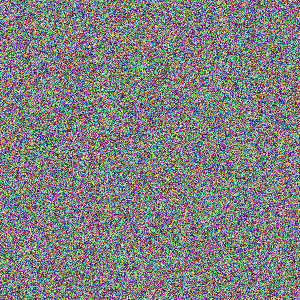

In [9]:
from torchvision.transforms.functional import to_pil_image

result = generator(torch.rand(3, 100))

img_results = recreate_img(result, IMG_SIZE)
display(to_pil_image(img_results[0]))

### Discriminador

In [10]:
class Discriminator(nn.Module):

    def __init__(self, img_size):
        """
            - *img_size*: image size (for square RGB images)
        """
        super().__init__()
        flattened_img_size = img_size*img_size*3

        self.layers = nn.Sequential(
            #nn.Flatten(),
            nn.Linear(flattened_img_size, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1),
            #nn.Sigmoid()
        )


    def forward(self, img):

        #img = img / 255
        output = self.layers(img)

        return output

In [11]:
discriminator = Discriminator(IMG_SIZE)

#### Testando discriminador

In [12]:
result.shape

torch.Size([3, 270000])

In [13]:
discriminator(result)

tensor([[0.0665],
        [0.0665],
        [0.0666]], grad_fn=<AddmmBackward0>)

## GAN

In [14]:
class GAN(nn.Module):

    def __init__(self, noise_size=100, img_size=300):
        """
            - *img_size*: image size (for square RGB images)
        """
        super().__init__()

        self.generator = Generator(noise_size, img_size)
        self.discriminator = Discriminator(img_size)

    def forward(self, noise_input):

        gen_output = self.generator(noise_input)
        final_output = self.discriminator(gen_output)

        return gen_output, final_output

In [59]:
model = GAN()

## Treinamento

## Auxiliares

In [ ]:
disc_optim = torch.optim.RMSprop(model.discriminator.parameters(), lr=LEARNING_RATE)
gen_optim = torch.optim.RMSprop(model.generator.parameters(), lr=LEARNING_RATE)

# Wasserstein Loss

def loss(model, real_imgs, noise_input):
    """
        - Returns:
            - L_d = D(x) - D(G(z)), L_g = D(G(z))

        First result is for the discriminator to maximize (or minimize its negative version). It returns the difference between the predictions for real samples and for fake samples.

        Second result is for the generator to maximize. It retursns the discriminator predictions for the fake data.
    """
    _, predictions_fake = model(noise_input)
    predictions_real = model.discriminator(real_imgs)

    return predictions_real.mean() - predictions_fake.mean(), -predictions_fake.mean()
    

In [17]:
#imgs, predictions = model(torch.randn(2, 100))

### Usando GPU

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
torch.cuda.empty_cache()

### Ciclo

In [41]:
from torch.utils.data import DataLoader
from tqdm import tqdm

model.train()

model = model.to(device)

epoch_gen_history = []
epoch_disc_history = []


# Interesting read for WGAN: https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/
# Reddit post: https://www.reddit.com/r/learnmachinelearning/comments/17cma9u/some_things_i_learned_about_gan_training/

# For each epoch
for epoch in tqdm(range(NUM_EPOCHS), desc='Epoch'):

    dl = iter(DataLoader(ds, BATCH_SIZE, shuffle=True))

    epoch_gen_loss = torch.scalar_tensor(0.0).to(device)
    epoch_disc_loss = torch.scalar_tensor(0.0).to(device)

    batch = next(dl, None)
    # for each batch
    while batch is not None:

        real_imgs, labels = batch
        real_imgs = real_imgs.reshape(real_imgs.shape[0], -1)
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)

        # generate noise input
        noise_input = torch.randn(BATCH_SIZE, 100)
        noise_input = noise_input.to(device)
            # generated_imgs, predictions = model(noise_input)

        # loss calculation
        loss_disc, loss_gen = loss(model, real_imgs, noise_input)
        epoch_gen_loss = torch.mean(torch.stack((loss_gen, epoch_gen_loss)))
        epoch_disc_loss = torch.mean(torch.stack((loss_disc, epoch_disc_loss)))

        # Loading next image
        batch = next(dl, None)

    
    # weight updates (generator)
    epoch_gen_loss.backward(retain_graph=True)

    # weight updates (discriminator)
    epoch_disc_loss.backward()


    # TRAINING GENERATOR --------------------------------------
    if epoch % 4 == 0:
        gen_optim.step()

    # TRAINING DISCRIMINATOR ----------------------------------
    disc_optim.step()

    # Zero Grad
    gen_optim.zero_grad()
    disc_optim.zero_grad()

    # Clamp Discriminator Weights (for WGAN)
    with torch.no_grad():
        for param in model.discriminator.parameters():
            param.clamp_(-0.01, 0.01)

    print(f'Epoch {epoch}:\ngen_loss = {epoch_gen_loss.item()} | disc_loss = {epoch_disc_loss.item()}')
    epoch_gen_history.append(epoch_gen_loss.item())
    epoch_disc_history.append(epoch_disc_loss.item())
    

Epoch:   3%|▎         | 1/30 [00:02<01:02,  2.17s/it]

Epoch 0:
gen_loss = -0.06022505462169647 | disc_loss = 0.003360383678227663


Epoch:   7%|▋         | 2/30 [00:04<00:59,  2.12s/it]

Epoch 1:
gen_loss = 0.3270641267299652 | disc_loss = -23.63295555114746


Epoch:  10%|█         | 3/30 [00:06<00:56,  2.08s/it]

Epoch 2:
gen_loss = 0.30730384588241577 | disc_loss = -303.307373046875


Epoch:  13%|█▎        | 4/30 [00:08<00:53,  2.07s/it]

Epoch 3:
gen_loss = 5.238980770111084 | disc_loss = -3787.47509765625


Epoch:  17%|█▋        | 5/30 [00:10<00:51,  2.07s/it]

Epoch 4:
gen_loss = 76.79995727539062 | disc_loss = -5530.87939453125


Epoch:  20%|██        | 6/30 [00:12<00:49,  2.07s/it]

Epoch 5:
gen_loss = 432.996337890625 | disc_loss = -6624.8544921875


Epoch:  23%|██▎       | 7/30 [00:14<00:47,  2.08s/it]

Epoch 6:
gen_loss = -7.359570503234863 | disc_loss = -9045.28125


Epoch:  27%|██▋       | 8/30 [00:16<00:46,  2.09s/it]

Epoch 7:
gen_loss = -12.73777961730957 | disc_loss = -12530.111328125


Epoch:  30%|███       | 9/30 [00:18<00:43,  2.08s/it]

Epoch 8:
gen_loss = -19.190628051757812 | disc_loss = -12773.0009765625


Epoch:  33%|███▎      | 10/30 [00:20<00:41,  2.10s/it]

Epoch 9:
gen_loss = -78.29598999023438 | disc_loss = -14108.103515625


Epoch:  37%|███▋      | 11/30 [00:23<00:40,  2.12s/it]

Epoch 10:
gen_loss = -109.90375518798828 | disc_loss = -14132.001953125


Epoch:  40%|████      | 12/30 [00:25<00:37,  2.10s/it]

Epoch 11:
gen_loss = -145.0205841064453 | disc_loss = -14545.939453125


Epoch:  43%|████▎     | 13/30 [00:27<00:36,  2.17s/it]

Epoch 12:
gen_loss = -183.48138427734375 | disc_loss = -15466.3388671875


Epoch:  47%|████▋     | 14/30 [00:29<00:34,  2.14s/it]

Epoch 13:
gen_loss = -78.2997817993164 | disc_loss = -16464.625


Epoch:  50%|█████     | 15/30 [00:31<00:31,  2.13s/it]

Epoch 14:
gen_loss = -260.859619140625 | disc_loss = -15111.7470703125


Epoch:  53%|█████▎    | 16/30 [00:33<00:29,  2.12s/it]

Epoch 15:
gen_loss = -321.2420654296875 | disc_loss = -15146.099609375


Epoch:  57%|█████▋    | 17/30 [00:35<00:27,  2.11s/it]

Epoch 16:
gen_loss = -376.5731506347656 | disc_loss = -16379.611328125


Epoch:  60%|██████    | 18/30 [00:37<00:25,  2.09s/it]

Epoch 17:
gen_loss = -412.2300720214844 | disc_loss = -14575.6171875


Epoch:  63%|██████▎   | 19/30 [00:39<00:22,  2.09s/it]

Epoch 18:
gen_loss = -433.8318176269531 | disc_loss = -15181.9375


Epoch:  67%|██████▋   | 20/30 [00:41<00:20,  2.08s/it]

Epoch 19:
gen_loss = -442.130615234375 | disc_loss = -16604.4453125


Epoch:  70%|███████   | 21/30 [00:44<00:18,  2.09s/it]

Epoch 20:
gen_loss = -446.77044677734375 | disc_loss = -14338.697265625


Epoch:  73%|███████▎  | 22/30 [00:46<00:16,  2.07s/it]

Epoch 21:
gen_loss = -450.63214111328125 | disc_loss = -12994.4140625


Epoch:  77%|███████▋  | 23/30 [00:48<00:14,  2.09s/it]

Epoch 22:
gen_loss = -454.6171875 | disc_loss = -16670.78125


Epoch:  80%|████████  | 24/30 [00:50<00:12,  2.08s/it]

Epoch 23:
gen_loss = -457.0201416015625 | disc_loss = -14473.91015625


Epoch:  83%|████████▎ | 25/30 [00:52<00:10,  2.08s/it]

Epoch 24:
gen_loss = -459.6195983886719 | disc_loss = -17346.419921875


Epoch:  87%|████████▋ | 26/30 [00:54<00:08,  2.07s/it]

Epoch 25:
gen_loss = -462.51055908203125 | disc_loss = -12882.1318359375


Epoch:  90%|█████████ | 27/30 [00:56<00:06,  2.07s/it]

Epoch 26:
gen_loss = -463.6080322265625 | disc_loss = -16929.736328125


Epoch:  93%|█████████▎| 28/30 [00:58<00:04,  2.07s/it]

Epoch 27:
gen_loss = -465.80096435546875 | disc_loss = -13537.06640625


Epoch:  97%|█████████▋| 29/30 [01:00<00:02,  2.07s/it]

Epoch 28:
gen_loss = -468.68597412109375 | disc_loss = -16642.275390625


Epoch: 100%|██████████| 30/30 [01:02<00:00,  2.09s/it]

Epoch 29:
gen_loss = -470.5606994628906 | disc_loss = -15130.642578125


[]

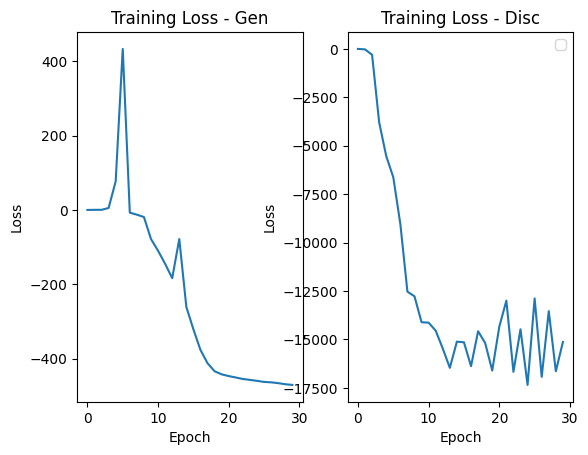

In [45]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2)

axes[0].set_title('Training Loss - Gen')
axes[0].plot(epoch_gen_history)
axes[1].set_title('Training Loss - Disc')
axes[1].plot(epoch_disc_history)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

plt.legend()

plt.plot()


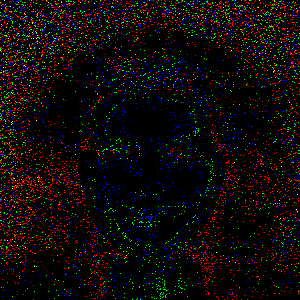

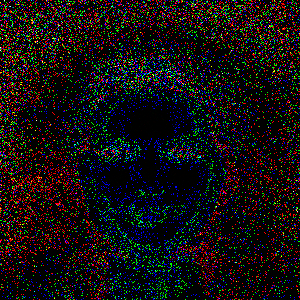

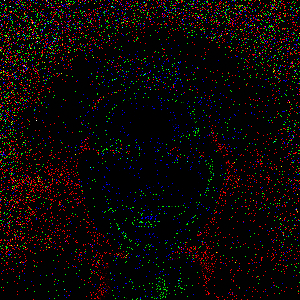

In [58]:
from torchvision.transforms.functional import to_pil_image

model.eval()

result = model.generator(torch.rand(3, 100).to(device))

result = recreate_img(result, IMG_SIZE)

display(to_pil_image(result[0]))
display(to_pil_image(result[1]))
display(to_pil_image(result[2]))

Gradient Penalty?

https://medium.com/@krushnakr9/gans-wasserstein-gan-with-gradient-penalty-wgan-gp-b8da816cb2d2